In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffractio import um, mm, nm, np, sp, plt, degrees
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY

from diffractio.vector_masks_XY import Vector_mask_XY
from diffractio.vector_sources_XY import Vector_source_XY

from diffractio.utils_drawing import draw_several_fields

number of processors: 8
total memory        : 15.5 Gb
available memory    : 61 %
max frequency       : 3100 GHz


In [3]:
from py_pol.jones_matrix import Jones_matrix
from py_pol.jones_vector import Jones_vector
from py_pol.mueller import Mueller
from py_pol.stokes import Stokes

In [4]:
from py_aocg.ifta.algorithms import distances_scalar, distances_vector
from py_aocg.ifta.algorithms import GS_scalar_far, GS_scalar_Fresnel, adaptative_far
from py_aocg.ifta.parameters import RMSE, diffraction_efficiency

py_aocg
number of processors: 8
total memory        : 15.5 Gb
available memory    : 61 %
max frequency       : 3100 GHz


## Objetivo

In [5]:
num_x=128
num_y=128
DOE_size=40*um

x=np.linspace(-DOE_size/2,DOE_size/2, num_x)
y=np.linspace(-DOE_size/2,DOE_size/2, num_y)
wavelength=0.6328*um

In [6]:
source=Scalar_source_XY(x,y,wavelength)
source.plane_wave()

In [7]:
wyrowsky_mask=Scalar_mask_XY(x,y,wavelength)
wyrowsky_mask.one_level(level=1)

In [8]:
target=Scalar_mask_XY(x,y,wavelength)
target.square(r0=(0,0), size=(10,10), angle=0)
target.circle(r0=(10,0), radius=(4,4), angle=0)
target.ring(r0=(0,0), radius1=10, radius2=12, angle=0)

target.draw(has_colorbar='vertical');

## Cargar Iluminación

In [9]:
# 1. Campo incidente vectorial 
j_incident=Jones_vector('incident')
j_incident.circular_light(intensity=1)
# j_incident.linear_light(intensity=2, azimuth=45*degrees)

incident = 
[+0.707+0.000j ]   
[+0.000+0.707j ]   

## Simular LIPSS

In [10]:
# 2. Cargar SLM

num_lipss = 8
angles = np.linspace(0, np.pi*(num_lipss-1)/num_lipss, num_lipss)
print(angles/degrees)

[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]


In [14]:
lipss = Jones_matrix('lipss')
lipss.diattenuator_perfect(azimuth=angles)
#lipss.retarder_azimuth_ellipticity( azimuth=angles, ellipticity=0.0*degrees)
print(lipss)

lipss J00 = [1.00000000e+00+0.j 8.53553391e-01+0.j 5.00000000e-01+0.j
 1.46446609e-01+0.j 3.74939946e-33+0.j 1.46446609e-01+0.j
 5.00000000e-01+0.j 8.53553391e-01+0.j]
      J01 = [ 0.00000000e+00+0.j  3.53553391e-01+0.j  5.00000000e-01+0.j
  3.53553391e-01+0.j  6.12323400e-17+0.j -3.53553391e-01+0.j
 -5.00000000e-01+0.j -3.53553391e-01+0.j]
      J10 = [ 0.00000000e+00+0.j  3.53553391e-01+0.j  5.00000000e-01+0.j
  3.53553391e-01+0.j  6.12323400e-17+0.j -3.53553391e-01+0.j
 -5.00000000e-01+0.j -3.53553391e-01+0.j]
      J11 = [0.        +0.j 0.14644661+0.j 0.5       +0.j 0.85355339+0.j
 1.        +0.j 0.85355339+0.j 0.5       +0.j 0.14644661+0.j]



In [15]:
j_fab = lipss * j_incident
print(j_fab)

lipss * incident = 
[+0.707+0.000j]   [+0.604+0.250j]   [+0.354+0.354j]   [+0.104+0.250j]   [+0.000+0.000j]   [+0.104-0.250j]   [+0.354-0.354j]   [+0.604-0.250j]   
[+0.000+0.000j]   [+0.250+0.104j]   [+0.354+0.354j]   [+0.250+0.604j]   [+0.000+0.707j]   [-0.250+0.604j]   [-0.354+0.354j]   [-0.250+0.104j]   



In [16]:
j_fab.draw_ellipse(subplots=None);

ValueError: NumPy boolean array indexing assignment cannot assign 8 input values to the 1 output values where the mask is true

In [17]:
# 3. E_fabricable
Ex_fab, Ey_fab = j_fab.parameters.components()

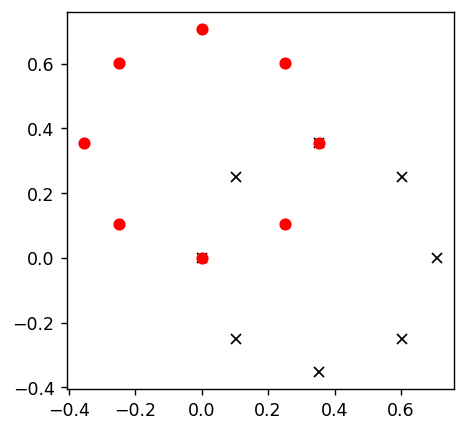

In [18]:
plt.plot(Ex_fab.real, Ex_fab.imag, 'kx')
plt.plot(Ey_fab.real, Ey_fab.imag, 'ro')

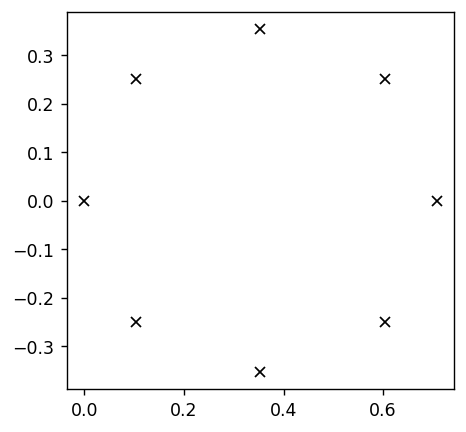

In [19]:
plt.plot(Ex_fab.real, Ey_fab.real, 'kx')

## IFTA fase estándar

Se realiza una optimización de distancias con IFTA estándard de fase

In [20]:
num_steps=50

In [21]:
def GS_vector_far(source,
                  target,
                  kind,
                  is_binary,
                  num_steps,
                  mask_wyrowsky=1,
                  phase=np.pi,
                  rmse='fast',
                  has_draw=False):
    """Gerbech-Saxton algorithm for the far field.

    Arguments:
        source (None or Scalar_field_XY): Illumination.
        target (Scalar_mask_XY): Objective.
        kind (str): 'phase' or 'amplitude'
        is_binary (bool): False or True
        num_steps (int): number of steps in the algorithm
        phase (float): phase for binary masks
        rmse (str): 'fast' or 'accurate'
        has_draw (bool): If True, draws the errors.

    Returns:
        DOE (Scalar_mask_XY): DOE which produces the algoritm
        mask_final (Scalar_mask_XY): mask of algorithm (for fabrication: 0-1).
        errors (np.array): Data of errors
    """

In [22]:
# 0. Inicializacion del algoritmo


x = target.x
y = target.y

num_x = len(x)
num_y = len(y)

wavelength = target.wavelength

phase= 2*np.pi

In [23]:
if source is None:
    source = 1

In [24]:
target_abs = np.fft.fftshift(np.abs(target.u))
I_target = target_abs**2

In [25]:
mask_wyrowsky=0
if isinstance(mask_wyrowsky, np.ndarray):
    wyrowsky_abs = np.fft.fftshift(np.abs(mask_wyrowsky))
    # wyrowsky_abs = np.abs(mask_wyrowsky)
else:
    wyrowsky_abs = 1.

In [26]:
# 2. Inicialización del campo
Ex = target_abs / np.sqrt(2) * np.exp(1j * 2 * phase * np.random.rand(num_y, num_x))
Ey = target_abs / np.sqrt(2) * np.exp(1j * 2 * phase * np.random.rand(num_y, num_x))

In [27]:
j_fab

lipss * incident = 
[+0.707+0.000j ]   [+0.604+0.250j ]   [+0.354+0.354j ]   [+0.104+0.250j ]   [+0.000+0.000j ]   [+0.104-0.250j ]   [+0.354-0.354j ]   [+0.604-0.250j ]   
[+0.000+0.000j ]   [+0.250+0.104j ]   [+0.354+0.354j ]   [+0.250+0.604j ]   [+0.000+0.707j ]   [-0.250+0.604j ]   [-0.354+0.354j ]   [-0.250+0.104j ]   

In [28]:
i=0
kind = 'phase'
is_binary = False

rmse = 'fast'

In [29]:
# 2. Inicialización del campo
Ex = target_abs / np.sqrt(2) * np.exp(1j * 2 * phase * np.random.rand(num_y, num_x))
Ey = target_abs / np.sqrt(2) * np.exp(1j * 2 * phase * np.random.rand(num_y, num_x))

errors = np.zeros(num_steps)

for i in range(num_steps):    # 6. Generate mask
    DOE_Ex = np.fft.ifft2(Ex)
    DOE_Ey = np.fft.ifft2(Ey)

    DOE_Ex = DOE_Ex * Ex_fab.max()/ DOE_Ex.max()
    DOE_Ey = DOE_Ey * Ey_fab.max() / DOE_Ey.max()
    
    # 7. Distances (but better with j_fab
    # 8. Substitution
    if i==0:
        print(DOE_Ex.max(), DOE_Ey.max(), Ex_fab.max(), Ey_fab.max())
        
    DOE_Ex, DOE_Ey, i_positions, distances = distances_vector(DOE_Ex, DOE_Ey, Ex_fab, Ey_fab)
    
    
    """
    if kind == 'amplitude':
        mask_x = np.abs(DOE_Ex)
        mask_x = mask_x / mask_x.max()

        mask_y = np.abs(DOE_Ey)
        mask_y = mask_y / mask_y.max()        
        
        if is_binary:
            mask_x = make_binary(mask_x, 0, 1, 0.5)
            mask_y = make_binary(mask_y, 0, 1, 0.5)
        DOE_Ex = mask_x
        DOE_Ey = mask_y

    elif kind == 'phase':
        mask_x = np.angle(DOE_Ex)
        mask_y = np.angle(DOE_Ey)
        
        if is_binary:
            mask_x = make_binary(mask_x, -phase / 2, phase / 2, 0)
            mask_y = make_binary(mask_y, -phase / 2, phase / 2, 0)

        DOE_Ex = np.exp(1j * mask_x)
        DOE_Ey = np.exp(1j * mask_y)
    """

    # 9. Propagación directa
    Ex = np.fft.fft2(DOE_Ex)  #field_z
    Ey = np.fft.fft2(DOE_Ey)  #field_z
    
    I_field = np.abs(Ex)**2 + np.abs(Ey)**2
    #I_field = I_field/I_field.max()
    
    #Ix=Ix/I_field.max()
    #Iy=Iy/I_field.max()
    
    #I_field = I_field * I_target.sum()/I_field.sum()

    # 9b. Cálclo del error
    if rmse == 'fast':
        error, factor = RMSE(I_field, I_target, fast=True)
    elif rmse == 'accurate':
        error, factor = RMSE(I_field, I_target, fast=False)
        
    print("{}/{} - error {:2.6f}".format(i, num_steps, error), end='\r')
    errors[i] = error

    # 10. substitución de los campos
    #Ex = Ex/I_field.max()
    Ix = np.abs(Ex)**2/2
    Iy = np.abs(I_target-Ix)
    #Iy[Iy<0]=0.
    Ex = np.sqrt(Ix)*np.exp(1j* np.angle(Ex))
    Ey = np.sqrt(Iy)*np.exp(1j * np.angle(Ey))
    
mask_Ex = np.fft.fftshift(DOE_Ex)
mask_Ey = np.fft.fftshift(DOE_Ey)
    

(0.7071067811865474+0j) (0.4909204839414624+0.0220939469834144j) (0.7071067811865475+0j) (0.35355339059327373+0.3535533905932737j)


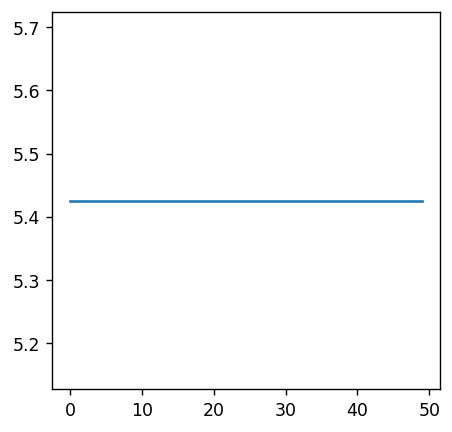

In [30]:
plt.plot(errors)

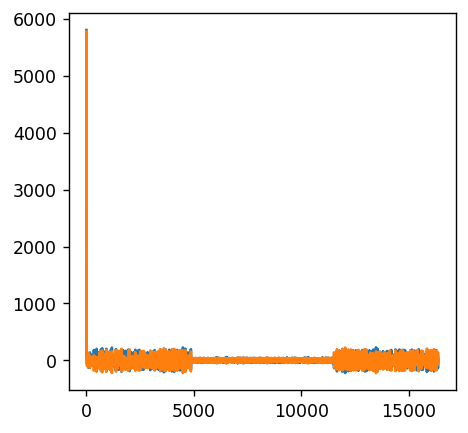

In [31]:
# Comprobación del resultado
Ex = np.fft.fft2(DOE_Ex)  #field_z
Ey = np.fft.fft2(DOE_Ey)  #field_z
plt.plot(Ex.flatten().real)
plt.plot(Ey.flatten().imag)

    i_wyrowsky = wyrowsky_abs > 0.5
    far_field_u[i_wyrowsky] = I_target[i_wyrowsky] * \
        np.exp(1j * np.angle(field_z[i_wyrowsky]))

    # i_wyrowsky = wyrowsky_abs < 0.5
    # far_field_u[i_wyrowsky] = field_z[i_wyrowsky] * \
    #     np.exp(1j * np.angle(field_z[i_wyrowsky]))

    # Meter aquí wyroswsky
    #
    #
    # far_field_u[i_wyrowsky] = ((lamda * I_target[i_wyrowsky] + (1 - lamda) *
    #                             field_ant[i_wyrowsky] * np.exp(1j * np.angle(far_field_u[i_wyrowsky]))))

In [32]:
    mask_final= Scalar_mask_XY(x, y, wavelength)
    mask_final.u = i_positions*1.

    
    DOE = Vector_source_XY(x, y, wavelength)
    DOE.Ex = DOE_Ex
    DOE.Ey = DOE_Ey
    
 

(array([2057., 2002., 2048., 2050., 1998., 2091., 2028., 2110.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

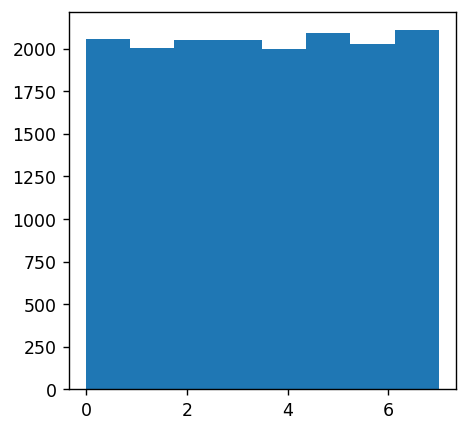

In [33]:
plt.hist(mask_final.u.flatten(), bins=num_lipss)

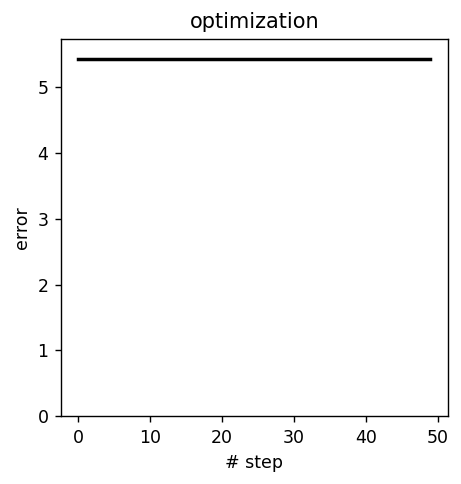

In [34]:
    has_draw = True
    
    if has_draw:
        plt.figure()
        plt.plot(errors, 'k', lw=2)
        plt.xlabel('# step')
        plt.ylabel('error')
        plt.title('optimization')
        plt.ylim(ymin=0)

 

In [35]:
#   return DOE, mask_final, errors

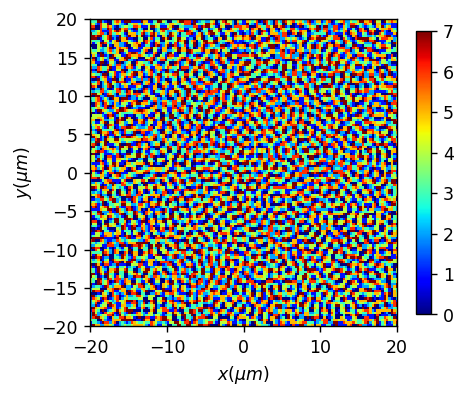

In [36]:
mask_final.draw(kind='amplitude',has_colorbar='vertical')
plt.clim(vmin=0)

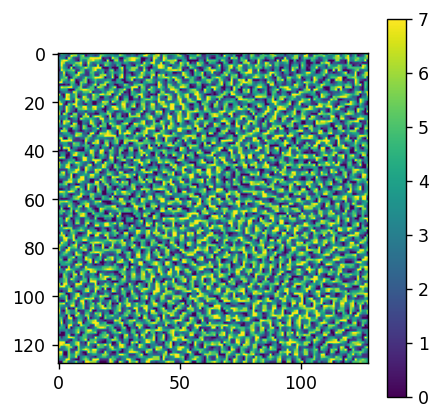

In [37]:
plt.imshow(i_positions)
plt.colorbar()

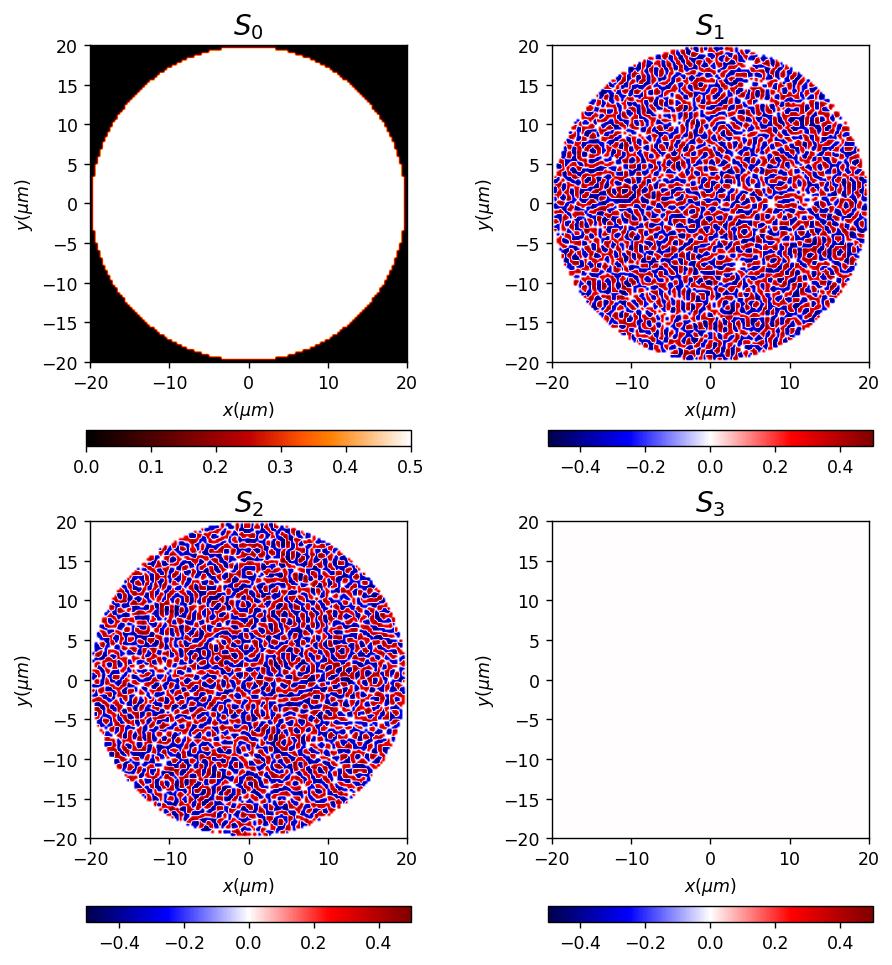

In [38]:
DOE.pupil()
DOE.draw(kind='stokes');

In [39]:
mask_center = Scalar_mask_XY(x,y,wavelength)
mask_center.circle(r0=(0,0), radius=1*um, angle=0)
mask_center.inverse_amplitude()
mask_center.draw();

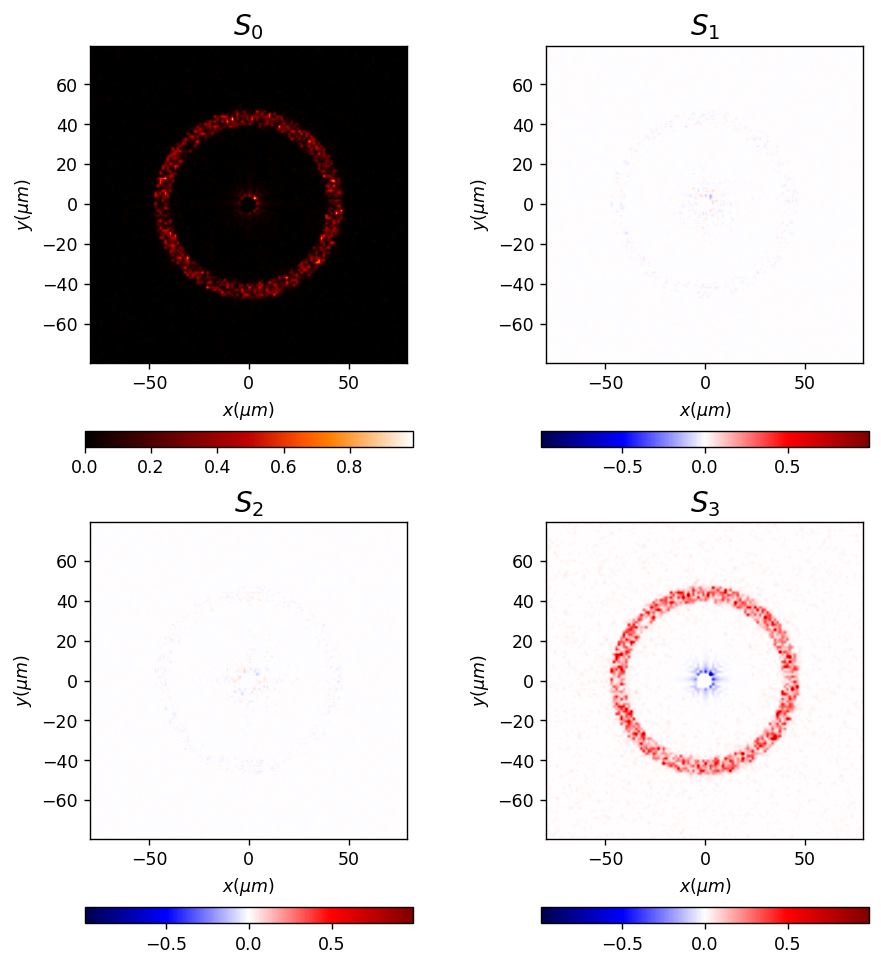

In [40]:
u_field=DOE.VFFT(focal=.05*mm, radius=5*mm, new_field=True)
u_field.apply_mask(mask_center)
u_field.normalize()
u_field.draw(kind='stokes');

In [41]:
u_field.intensity().max()

1.0000000000000002

## Máscara
La máscara es espacial y en cada punto tenemos una matriz de Jones (2x2). Para calcularla tenemos que buscar las posiciones i_positions y en cada una de ellas poner las j_fab

In [42]:
J_doe = Vector_mask_XY(x, y, wavelength)

for i in range(num_lipss):
    J_doe.M00[i_positions==i]=lipss[i].M[0,0]
    J_doe.M01[i_positions==i]=lipss[i].M[0,1]
    J_doe.M10[i_positions==i]=lipss[i].M[1,0]
    J_doe.M11[i_positions==i]=lipss[i].M[1,1]

<Figure size 500x500 with 0 Axes>

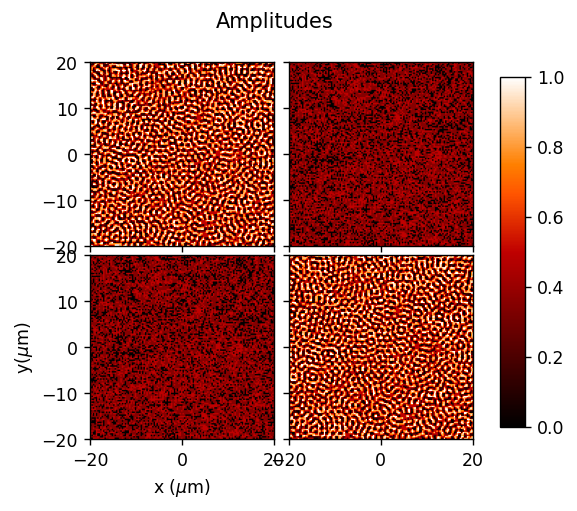

In [43]:
J_doe.draw()

## Iluminacion

In [ ]:
j_incident[0].parameters.components()

In [ ]:
J_ilum = Vector_source_XY(x, y, wavelength)
J_ilum.constant_wave(v=j_incident[0].parameters.components())

## Verifación del sistema

In [ ]:
type(J_doe), type(J_ilum)

In [ ]:
J1 = J_ilum * J_doe  
J1.pupil()

In [ ]:
J1.draw(kind='stokes');

In [ ]:
J1.draw();

In [ ]:
J_far=J1.VFFT(focal=.05*mm, radius=5*mm, new_field=True)
J_far.apply_mask(mask_center)
J_far.normalize()
J_far.draw(kind='stokes');

In [ ]:
J_far.draw(kind='intensity');